In [1]:
# solo ejecutar si esta en colab y necesita instalar librerias
!pip install surprise
!pip install sns

In [2]:
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from itertools import product

from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import GridSearchCV

%matplotlib inline

# MINE 4201- Laboratorio 3 - SR por factorización

En este laboratorio se ajustará un modelo de factorización utilizando el framework Surprise:
https://surprise.readthedocs.io/en/stable/index.html

Los datos fueron previamente separados en conjunto de entrenamiento, validación y test.

## 1. Exploración de los datasets de entrenamiento, validación y prueba

Ejecute las siguientes líneas y concluya sobre cómo están construidos estos datasets

In [3]:
pwd

'C:\\Users\\Asus\\Desktop\\MAESTRIA\\2021 - 01\\Sistemas de recomendacion\\Laboratorio 3'

In [4]:
#Cambie el path de los datos dependiendo de donde estan (máquina local o google colab)

In [5]:
if os.path.exists('C:\\Users\\Asus\\Desktop\\MAESTRIA\\2021 - 01\\Sistemas de recomendacion\\Laboratorio 3\\data\\') :
    print("La ruta de los archivos si existe.")
    path = 'C:\\Users\\Asus\\Desktop\\MAESTRIA\\2021 - 01\\Sistemas de recomendacion\\Laboratorio 3\\data\\'
elif os.path.exists('C:\\Users\\Ovalles\\Dropbox\\Mi PC (LAPTOP-K1R3F85D)\\Desktop\\MAESTRIA\\2021 - 01\\Sistemas de recomendacion\\Laboratorio 3\\data\\'):
    print("La ruta de los archivos si existe.")
    path = 'C:\\Users\\Ovalles\\Dropbox\\Mi PC (LAPTOP-K1R3F85D)\\Desktop\\MAESTRIA\\2021 - 01\\Sistemas de recomendacion\\Laboratorio 3\\data\\'
else:
    raise ValueError('La ruta de los archivos no existe.')

La ruta de los archivos si existe.


In [6]:
print(path)

C:\Users\Asus\Desktop\MAESTRIA\2021 - 01\Sistemas de recomendacion\Laboratorio 3\data\


In [7]:
train_df = pd.read_csv( path+'train', sep = '::', names = [ 'user_id', 'item_id', 'rating', 'timestamp' ], engine = 'python' )
validation_df = pd.read_csv( path+'validation', sep = '::', names = [ 'user_id', 'item_id', 'rating', 'timestamp'], engine = 'python' )
test_df = pd.read_csv( path+'test', sep = '::', names = [ 'user_id', 'item_id', 'rating', 'timestamp' ], engine = 'python' )
movies_df=pd.read_csv(path+'movies.csv')

In [8]:
train_df.head( 5 )

user_id  item_id  rating  timestamp
0      181      930       1  878963275
1       13       72       4  882141727
2       13      181       5  882140354
3      181      619       3  878963086
4      181      334       1  878961749

La tabla de entrenamiento trae el identificador del usuario, el identificador del item, la calificación dada por el usuario al item correspondiente y la fecha de calificación.

<AxesSubplot:ylabel='Frequency'>

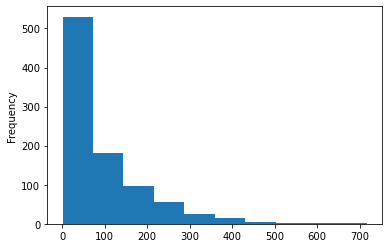

In [9]:
train_df['user_id'].value_counts().plot.hist()

La grafica anterior nos indica la distribución del conteo de items calificados por los usuarios. Por ejemplo, como solo hay un usuario que realizó mas de 700 calificaciones a items, la barra es muy pequeña. Por otro lado, como la mayoria de usuarios tienen por lo menos 1 calificacion la barra es muy grande.

<AxesSubplot:ylabel='Frequency'>

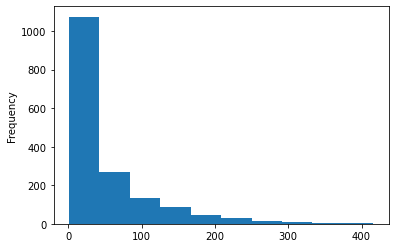

In [10]:
train_df['item_id'].value_counts().plot.hist()

La grafica anterior nos indica la distribución del conteo de ratings disponibles para cada item. Por ejemplo, como solo hay un item con mas de 400 calificaiones, la barra es muy pequeña. Por otro lado, como la mayoria de items tienen por lo menos 1 rating disponible, la barra es muy grande.

In [11]:
movies_df.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

La tabla de movies_df trae información adicional sobre cada item. Especificamente, trae el nombre de la pelicula con el año de estreno, y los distintos generos asociados a la pelicula separados por '|'. Esta información se puede añadir a las tablas de entrenamiento y prueba a partir de un join.

In [12]:
conteo_peliculas = train_df['item_id'].value_counts().to_frame()

In [13]:
conteo_peliculas.columns = ['conteo']

In [14]:
conteo_peliculas = conteo_peliculas.merge(movies_df, how='left', right_on='movieId', left_index=True)

In [15]:
conteo_peliculas.head(20)

conteo  movieId                                              title  \
49.0      416       50                         Usual Suspects, The (1995)   
179.0     386      181     Mighty Morphin Power Rangers: The Movie (1995)   
98.0      372      100                                   City Hall (1996)   
0.0       345        1                                   Toy Story (1995)   
172.0     343      174                                   Jury Duty (1995)   
119.0     336      121                    Boys of St. Vincent, The (1992)   
96.0      315       98                                    Shopping (1994)   
290.0     315      294                           Perez Family, The (1995)   
255.0     312      258               Kid in King Arthur's Court, A (1995)   
55.0      312       56                     Kids of the Round Table (1995)   
125.0     312      127  Silences of the Palace, The (Saimt el Qusur) (...   
283.0     301      286                           Nemesis 2: Nebula (1995)   
6.0       293        7                                     Sabrina (1995)   
170.0     291      172                             Johnny Mnemonic (1995)   
285.0     289      288                        Natural Born Killers (1994)   
78.0      286       79                                  Juror, The (1996)   
234.0     285      237                                Forget Paris (1995)   
202.0     283      204               Under Siege 2: Dark Territory (1995)   
115.0     282      117              Young Poisoner's Handbook, The (1995)   
166.0     278      168                                First Knight (1995)   

                                            genres  
49.0                        Crime|Mystery|Thriller  
179.0                              Action|Children  
98.0                                Drama|Thriller  
0.0    Adventure|Animation|Children|Comedy|Fantasy  
172.0                                       Comedy  
119.0                                        Drama  
96.0                               Action|Thriller  
290.0                               Comedy|Romance  
255.0    Adventure|Children|Comedy|Fantasy|Romance  
55.0             Adventure|Children|Comedy|Fantasy  
125.0                                        Drama  
283.0                       Action|Sci-Fi|Thriller  
6.0                                 Comedy|Romance  
170.0                       Action|Sci-Fi|Thriller  
285.0                        Action|Crime|Thriller  
78.0                                Drama|Thriller  
234.0                               Comedy|Romance  
202.0                                       Action  
115.0                                  Crime|Drama  
166.0                         Action|Drama|Romance

La tabla conteo_peliculas es el resultado de unir el conteo de items calificados en la tabla de entrenamiento y la tabla auxiliar movies_df. De esta forma, se obtiene una tabla con el id del item, el numero de veces que fue calificado en entrenamiento, el nombre de la pelicula y los generos asociados a esta.

In [16]:
validation_df.head( 5 )

user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596

La tabla de validación trae las mismas columnas disponibles en la base de entrenamiento. Esta sera utilizada para ajustar los hiperparametros del algoritmo que se utilizara.

In [17]:
test_df.head( 5 )

user_id  item_id  rating  timestamp
0       13      498       4  882139901
1       13      892       3  882774224
2       13      229       4  882397650
3      181      741       1  878962918
4      181     1015       1  878963121

La tabla de prueba trae, de igual forma, las mismas columnas que entrenamiento y validación. Esta sera utilizada para medir la capacidad de generalización del algoritmo utilizado.

In [18]:
train_df[['rating','timestamp']].describe()

rating     timestamp
count  81140.000000  8.114000e+04
mean       3.516207  8.834829e+08
std        1.126096  5.340285e+06
min        1.000000  8.747247e+08
25%        3.000000  8.794481e+08
50%        4.000000  8.826785e+08
75%        4.000000  8.881927e+08
max        5.000000  8.932866e+08

rating
1     5043
2     9345
3    22276
4    27636
5    16840
dtype: int64

<AxesSubplot:ylabel='Frequency'>

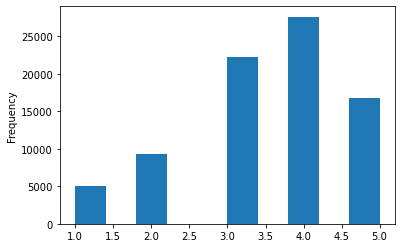

In [19]:
display(train_df.groupby('rating').size())
train_df.rating.plot.hist()

La grafica anterior muestra la frecuencia de cada posible calificación dentro de la tabla de entrenamiento. Se logra ver que la gran mayoria de calificaciones estan dentro del intervalo [3,4]. Así, se puede afirmar que la mayoria de usuarios son aversos a realizar calificaciones muy negativas.

In [20]:
validation_df[['rating','timestamp']].describe()

rating     timestamp
count  9430.000000  9.430000e+03
mean      3.587805  8.837354e+08
std       1.120240  5.360562e+06
min       1.000000  8.747247e+08
25%       3.000000  8.794515e+08
50%       4.000000  8.833904e+08
75%       4.000000  8.886378e+08
max       5.000000  8.932866e+08

rating
1     542
2     995
3    2424
4    3316
5    2153
dtype: int64

<AxesSubplot:ylabel='Frequency'>

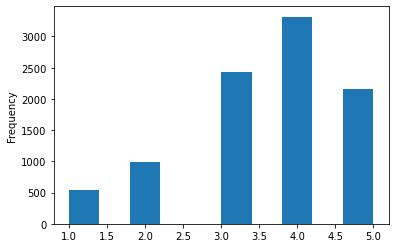

In [21]:
display(validation_df.groupby('rating').size())
validation_df.rating.plot.hist()

La grafica anterior muestra la frecuencia de cada posible calificacion dentro de la tabla de validación. Se logra evidenciar el mismo comportamiento que se presenta dentro del conjunto de entrenamiento.

In [22]:
test_df[['rating','timestamp']].describe()

rating     timestamp
count  9430.000000  9.430000e+03
mean      3.589396  8.837179e+08
std       1.123800  5.349370e+06
min       1.000000  8.747249e+08
25%       3.000000  8.794518e+08
50%       4.000000  8.833653e+08
75%       4.000000  8.886326e+08
max       5.000000  8.932866e+08

rating
1     525
2    1030
3    2445
4    3222
5    2208
dtype: int64

<AxesSubplot:ylabel='Frequency'>

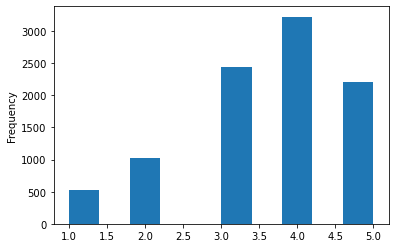

In [23]:
display(test_df.groupby('rating').size())
test_df.rating.plot.hist()

La grafica anterior muestra la frecuencia de cada posible calificacion dentro de la tabla de prueba. Se logra evidenciar el mismo comportamiento que se presenta dentro del conjunto de entrenamiento y validación.

In [24]:
print( 'Train size: ' + str( train_df.shape ) )
print('Validation size: ' + str( validation_df.shape ) )
print( 'Test size: ' + str( test_df.shape ) )

Train size: (81140, 4)
Validation size: (9430, 4)
Test size: (9430, 4)


In [25]:
# En movies queda la información sobre las películas y su id
movies_df.head()

movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy

## 2. Transformación de los dataset al formato de Surprise

El framework lee los dataframes de pandas y los transforma a un formato que es aceptado por él

In [26]:
# Se establece el rango en el cual se aceptaran los ratings
reader = Reader( rating_scale = ( 1, 5 ) )

In [27]:
# Transformación de los datasets, puede leer los datasets directamente desde el disco sin necesidad de pasar por pandas
train_data = Dataset.load_from_df( train_df[ [ 'user_id', 'item_id', 'rating' ] ], reader )
validation_data = Dataset.load_from_df( validation_df[ [ 'user_id', 'item_id', 'rating' ] ], reader )
test_data = Dataset.load_from_df( test_df[ [ 'user_id', 'item_id', 'rating' ] ], reader )

In [28]:
# Surprise requiere que explicitamente los datasets sean transformados a datasets de entrenamiento y prueba en cada caso 
# Si bien no se entrenará sobre los datasets de validación y prueba, surprise requiere que sean tranformados a entrenamiento para posteriormente ser transformados a prueba
train_data = train_data.build_full_trainset()
validation_data = validation_data.build_full_trainset()
test_data = test_data.build_full_trainset()

In [29]:
# Finalmente, se convierten los 3 datasets a prueba ya que se medirá el error obtenido en los 3
train_data_2 = train_data.build_testset()
validation_data = validation_data.build_testset()
test_data = test_data.build_testset()

Cada película queda representada en el conjunto train con un id interno para los modelos de factorización, revise la documentación sobre ids internos y externos [aqui](https://surprise.readthedocs.io/en/stable/FAQ.html#raw-inner-note)

In [30]:
movies_df.loc[movies_df.movieId == 1]

movieId             title                                       genres
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy

In [31]:
#Revisar el id interno de la película con id 1 en el dataset
train_data.to_inner_iid(1)

16

## 3. Entrenamiento de un modelo SVD con bias

El modelo toma como base el promedio global. En este caso es de 3.5162

In [32]:
mean = train_data.global_mean
print( mean )

3.516206556568893


La clase SVD recibe los siguientes parámetros:
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD
* n_factors: Número k de factores para realizar la recomendación
* n_epochs: Número de iteraciones a realizar sobre los datos
* biased: Si el modelo contempla los bias o solo la factorización
* lr_all: Tasa de aprendizaje del método
* reg_all: Parámetro de regularización
* init_mean y init_std_dev son los parámetros de la distribución usada para inicializar aleatoriamente los factores

Se prueba un modelo con bias sin regularización para k=5




In [33]:
algo = SVD( n_factors = 5, n_epochs = 200, biased = True, lr_all = 0.001, reg_all = 0, init_mean = 0, init_std_dev = 0.01, verbose = True )

In [34]:
# Se realiza el entrenamiento a partir del dataset debido
algo.fit( train_data )

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
Processing

Al finalizar el entrenamiento, se visualiza cómo quedo la matriz que representa a los usuarios ($p_u$) y la matriz que representa a los items ($q_i$)

In [35]:
pu = algo.pu

In [36]:
pu.shape

(911, 5)

<AxesSubplot:>

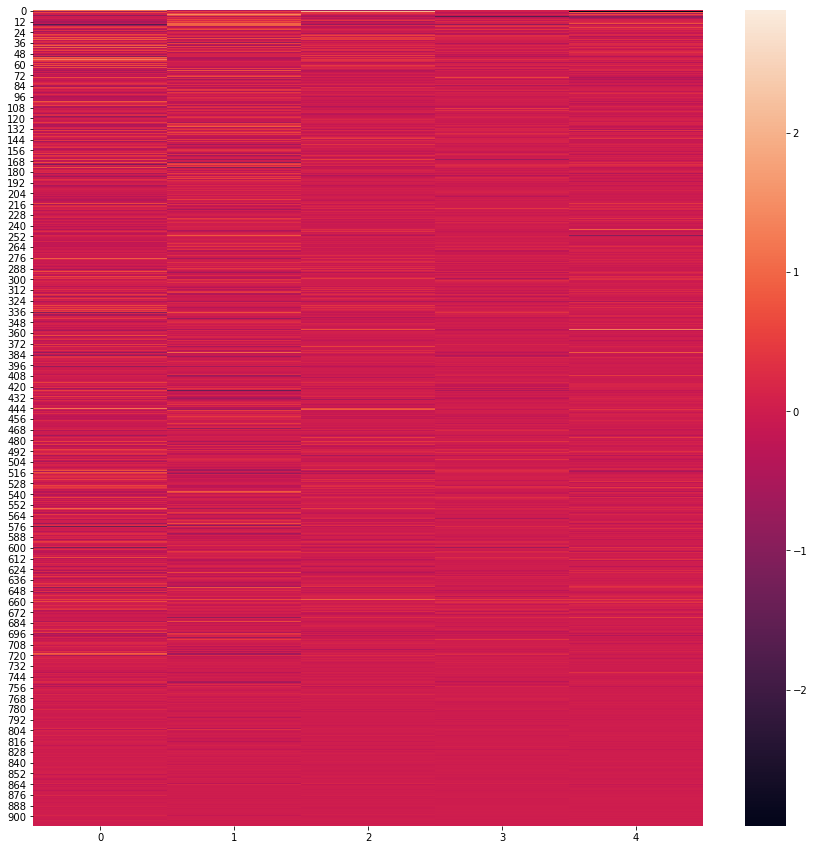

In [37]:
fig, ax =  plt.subplots(figsize=(15,15)) 
sns.heatmap( pu, ax = ax )

In [38]:
qi = algo.qi

<AxesSubplot:>

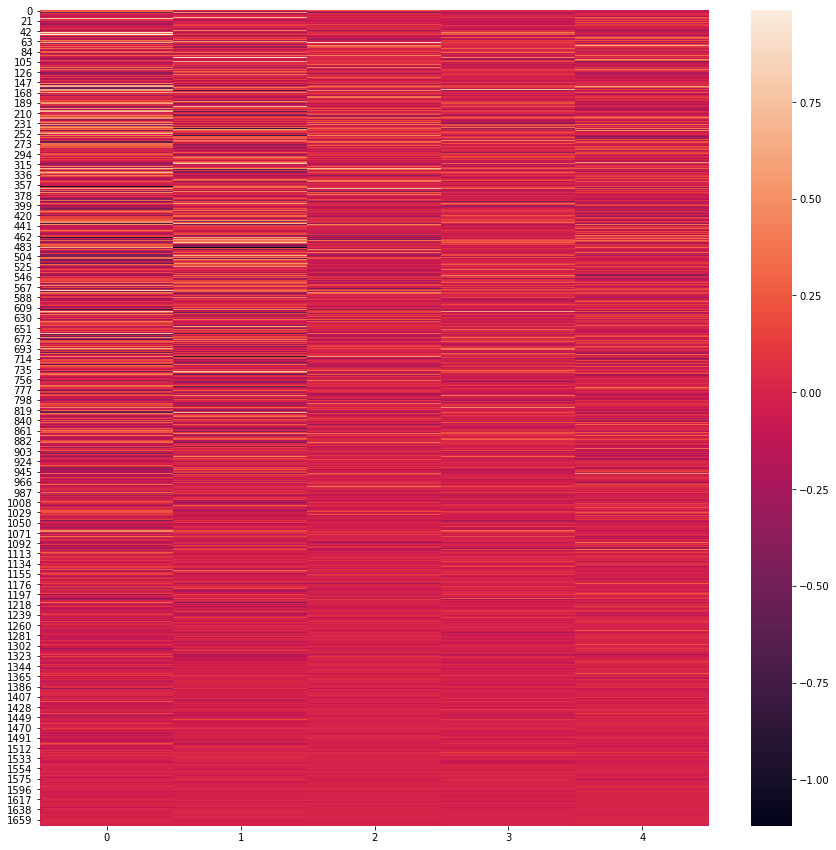

In [39]:
fig, ax =  plt.subplots(figsize=(15,15)) 
sns.heatmap( qi , ax = ax)

También se pueden visualizar los bias de usuarios e items $b_u$ y $b_i$

In [40]:
bi = algo.bi.reshape( algo.bi.shape[ 0 ], 1 )
bu = algo.bu.reshape( algo.bu.shape[ 0 ], 1 )

<AxesSubplot:>

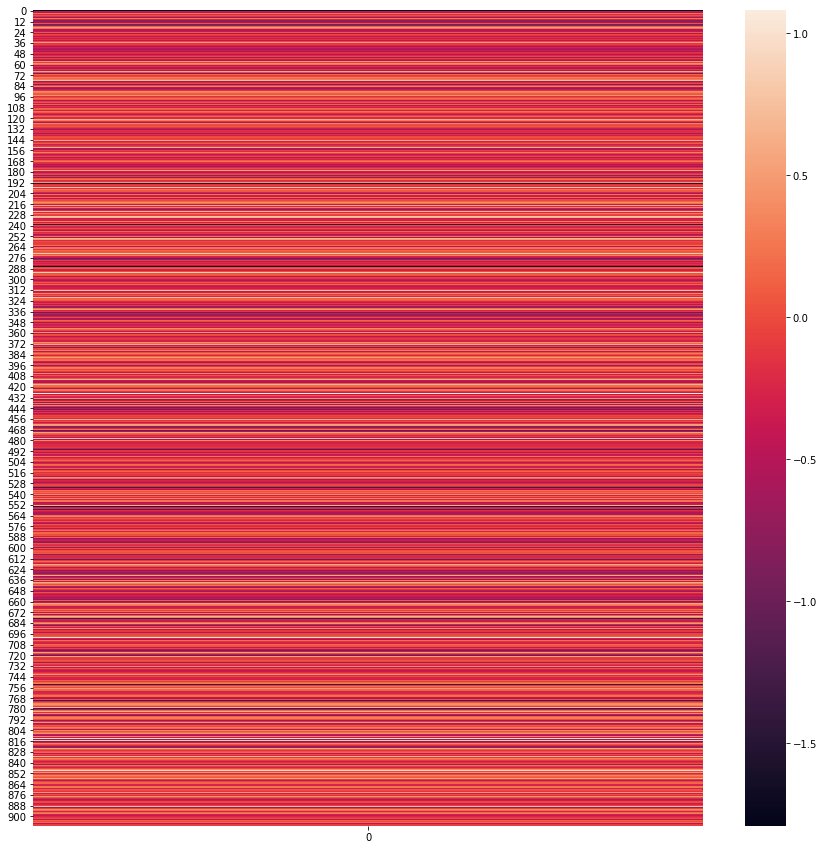

In [41]:
fig, ax =  plt.subplots(figsize=(15,15)) 
sns.heatmap( bu ,ax = ax)

<AxesSubplot:>

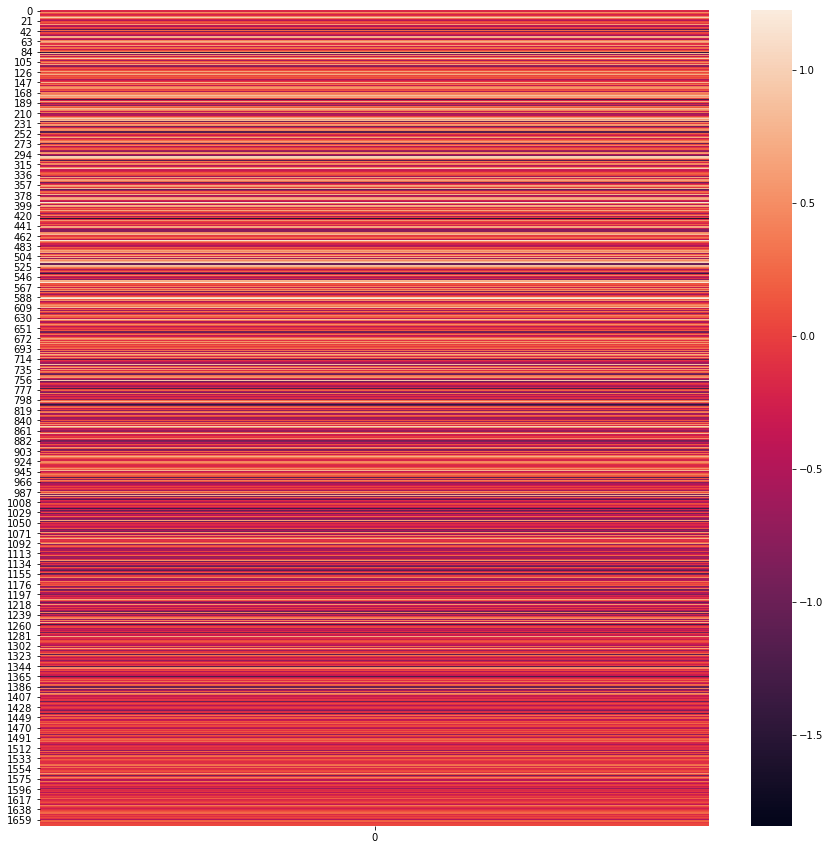

In [42]:
fig, ax =  plt.subplots(figsize=(15,15)) 

sns.heatmap( bi, ax = ax )

In [43]:
bi.shape

(1672, 1)

In [44]:
# Ejemplo bias de película con id 1
bi[train_data.to_inner_iid(1)]

array([0.49934655])

In [45]:
#Película con el máximo bias

In [46]:
np.amax(bi)

1.2236581377077373

In [47]:
np.where(bi==np.amax(bi))

(array([591], dtype=int64), array([0], dtype=int64))

In [48]:
bi[591]

array([1.22365814])

In [49]:
#Bias del item con inner_id 1534
bi[1534]

array([1.15071019])

In [50]:
#Se obtiene el id original del item
train_data.to_raw_iid(1534)

1449

In [51]:
#Se utiliza la tabla conteo_peliculas para ver la información del item 1449
conteo_peliculas[conteo_peliculas.movieId == train_data.to_raw_iid(1534)]

conteo  movieId                       title  genres
1409.0       7     1449  Waiting for Guffman (1996)  Comedy

In [52]:
#Se filtra la tabla de entrenamiento con la pelicula Waiting for Guffman
train_df[train_df.item_id == train_data.to_raw_iid(1534)]

user_id  item_id  rating  timestamp
32518      561     1449       5  885808620
33292      409     1449       5  881107817
39592      585     1449       5  891283338
50049      385     1449       4  881047049
56498      934     1449       5  891191976
63269      234     1449       4  892333573
75662      932     1449       5  891248937

### Reconstrucción de la matriz original

Una vez se realiza la factorización, se puede reconstruir la predicción para cada una de las coordenadas de la matriz original

$\hat{r}_{ui}= \mu + b_{i} + b_{u} + p_{u}\dot q_{i}^{T} $

In [53]:
reconstruct = ( pu ).dot( ( qi ).T ) + bu + bi.T + mean

<AxesSubplot:>

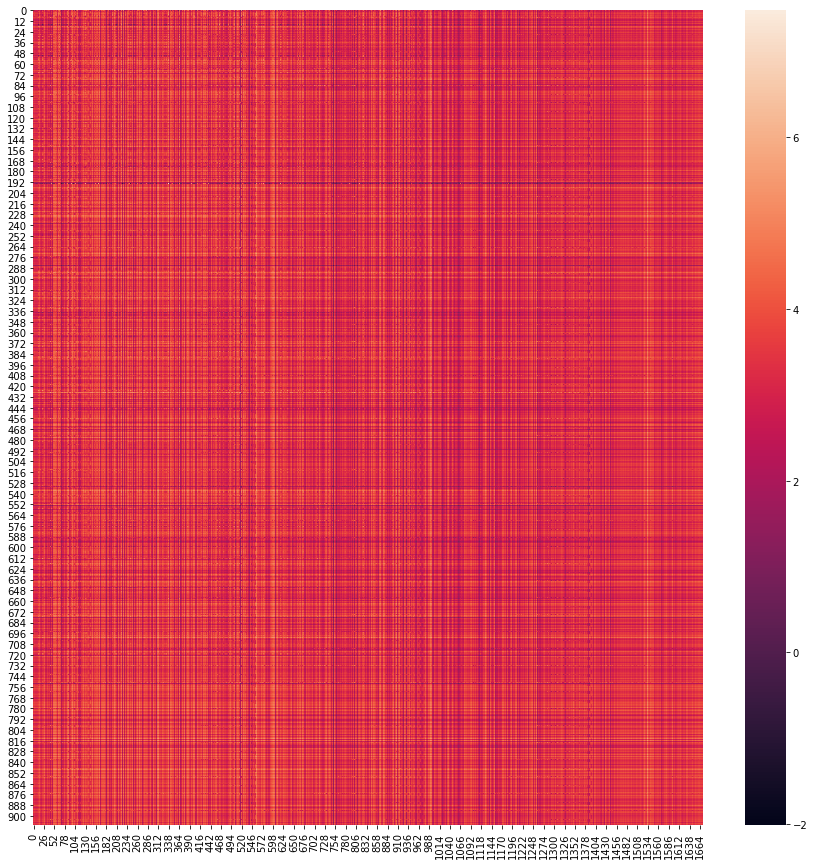

In [54]:
fig, ax =  plt.subplots(figsize=(15,15)) 
sns.heatmap( reconstruct, ax = ax )

<AxesSubplot:>

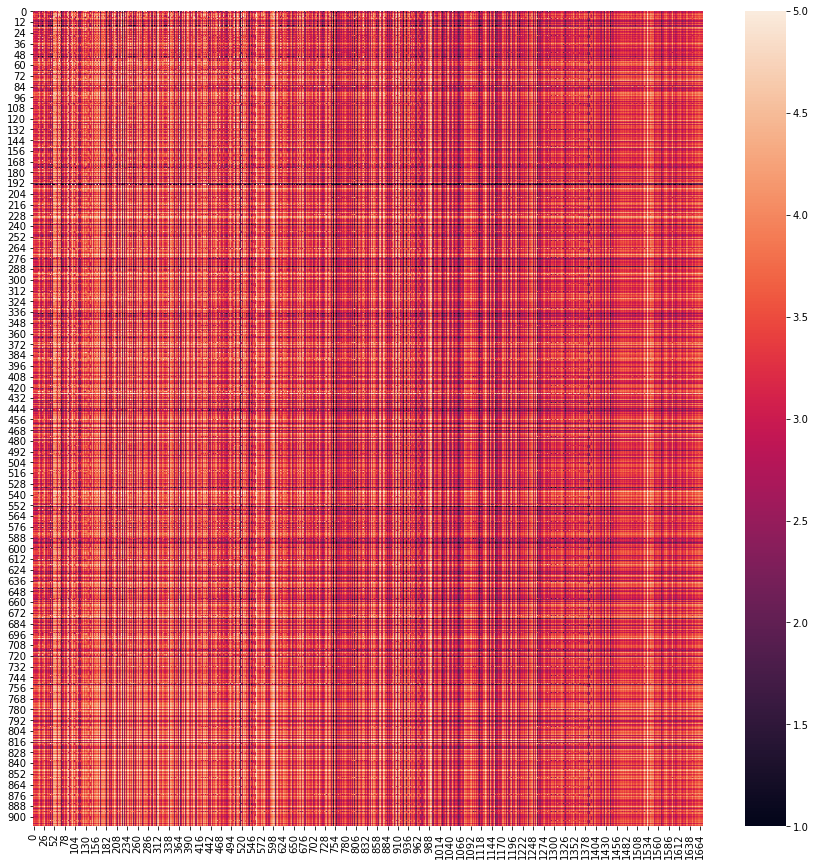

In [55]:
# Ya que algunos ratings reconstruidos están fuera del rango aceptado, se realiza un ajuste entre 1 y 5
reconstruct = np.clip( reconstruct, 1, 5 )
fig, ax =  plt.subplots(figsize=(15,15)) 

sns.heatmap( reconstruct , ax = ax)

Compare los resultados con la matriz original:

In [56]:
original = np.zeros( ( train_data.n_users , train_data.n_items ) )
for ( u, i, r ) in train_data.all_ratings():
    original[ u ][ i ] = r

<AxesSubplot:>

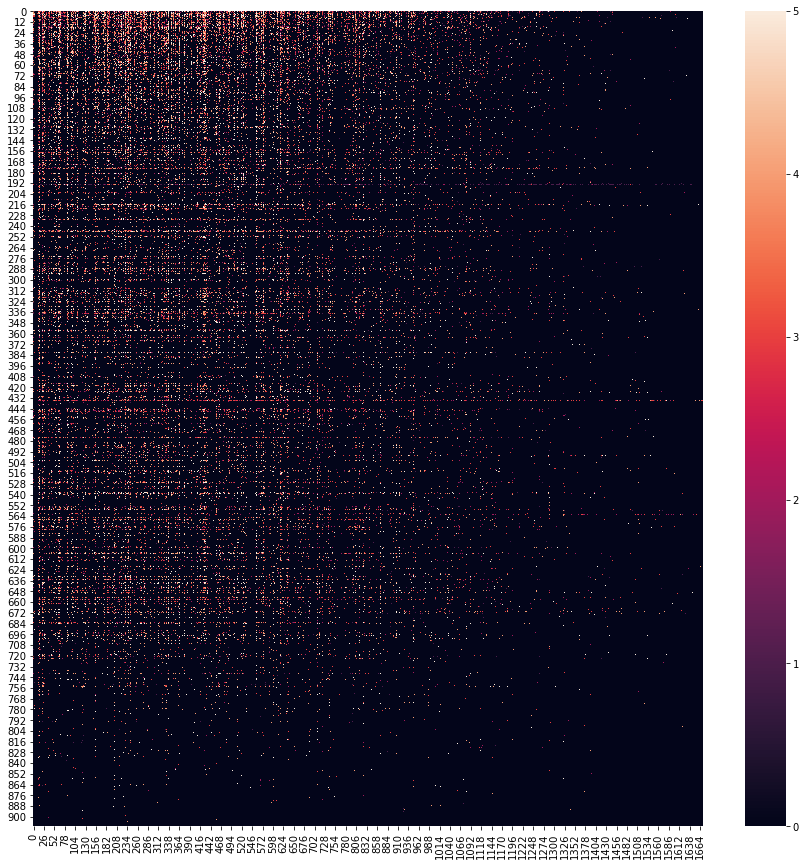

In [57]:
fig, ax =  plt.subplots(figsize=(15,15)) 
sns.heatmap( original, ax = ax )

In [58]:
original

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 4., 5., ..., 0., 0., 0.],
       [0., 4., 4., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Se compara visualmente el error en las entradas conocidas de la matriz ( error en conjunto de entrenamiento )

In [59]:
known_entries = original == 0

In [60]:
reconstruct[ known_entries ] = 0

<AxesSubplot:>

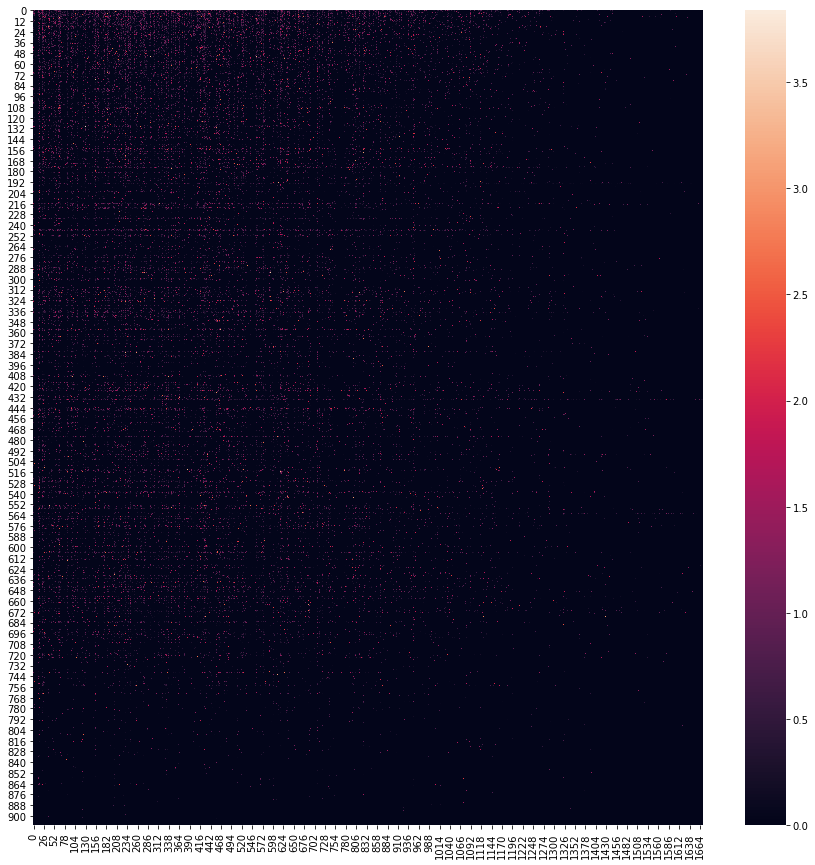

In [61]:
fig, ax =  plt.subplots(figsize=(15,15)) 

sns.heatmap( np.abs( original - reconstruct ) , ax = ax)

## 3. Evaluación de predicciones

A partir del modelo entrenado, se mide el error del modelo en el conjunto de entrenamiento, validación y prueba

In [62]:
predictions_train = algo.test( train_data_2 )

In [63]:
predictions_validation = algo.test( validation_data )
predictions_test = algo.test( test_data )

In [64]:
accuracy.rmse( predictions_train, verbose = True )

RMSE: 0.8375


0.8374679032338425

In [65]:
accuracy.rmse( predictions_validation, verbose = True )

RMSE: 0.9593


0.9592712514102042

In [66]:
accuracy.rmse( predictions_test, verbose = True )

RMSE: 0.9742


0.9742263365597825

## 4. Selección de hiper-parámetros

Utilice este notebook para realizar los siguientes ajustes:

4.1 Aumente el número k de dimensiones del vector y documente los resultados. Evidencie el efecto que tiene esta variación en los parámetros obtenidos y en los errores (cree una gráfica donde muestre el efecto que tiene k sobre los errores)

4.2 Para un k fijo, aumente la regularización para diferentes valores [0.001,0.01,0.1,1,10].  Evidencie el efecto que tiene esta variación en los parámetros obtenidos y en los errores, por ejemplo, comparando los tamaños de los parámetros.

4.3 ¿Según los resultados obtenidos, qué otros hiperparámetros cambiaría y en qué dirección para mejorar el performance del modelo?

### 4.1 Aumente el número k de dimensiones del vector y documente los resultados. Evidencie el efecto que tiene esta variación en los parámetros obtenidos y en los errores (cree una gráfica donde muestre el efecto que tiene k sobre los errores)

In [67]:
train_data = Dataset.load_from_df(train_df[[ 'user_id', 'item_id', 'rating' ]], reader)
train_data = train_data.build_full_trainset()

<font color='red'>Nota: no correr las siguiente celda. Tiempo de ejecución alto. </font> 

In [68]:
%%time
rmse_1 = []

for each in range(6, 100):  
    algo = SVD(n_factors = each, n_epochs = 200, biased = True,lr_all = 0.001,reg_all = 0,init_mean = 0,init_std_dev = 0.01,verbose = False)
    algo.fit(train_data) 
    predictions = algo.test(validation_data)
    rmse_1.append(accuracy.rmse(predictions))

RMSE: 0.9597
RMSE: 0.9575
RMSE: 0.9583
RMSE: 0.9570
RMSE: 0.9569
RMSE: 0.9571
RMSE: 0.9542
RMSE: 0.9569
RMSE: 0.9558
RMSE: 0.9551
RMSE: 0.9557
RMSE: 0.9538
RMSE: 0.9545
RMSE: 0.9555
RMSE: 0.9550
RMSE: 0.9521
RMSE: 0.9539
RMSE: 0.9532
RMSE: 0.9544
RMSE: 0.9539
RMSE: 0.9539
RMSE: 0.9531
RMSE: 0.9527
RMSE: 0.9528
RMSE: 0.9528
RMSE: 0.9541
RMSE: 0.9524
RMSE: 0.9521
RMSE: 0.9501
RMSE: 0.9512
RMSE: 0.9532
RMSE: 0.9523
RMSE: 0.9519
RMSE: 0.9521
RMSE: 0.9489
RMSE: 0.9513
RMSE: 0.9520
RMSE: 0.9529
RMSE: 0.9518
RMSE: 0.9524
RMSE: 0.9519
RMSE: 0.9527
RMSE: 0.9531
RMSE: 0.9507
RMSE: 0.9544
RMSE: 0.9519
RMSE: 0.9518
RMSE: 0.9524
RMSE: 0.9514
RMSE: 0.9508
RMSE: 0.9519
RMSE: 0.9487
RMSE: 0.9506
RMSE: 0.9490
RMSE: 0.9511
RMSE: 0.9499
RMSE: 0.9502
RMSE: 0.9511
RMSE: 0.9496
RMSE: 0.9512
RMSE: 0.9491
RMSE: 0.9524
RMSE: 0.9503
RMSE: 0.9511
RMSE: 0.9491
RMSE: 0.9507
RMSE: 0.9524
RMSE: 0.9504
RMSE: 0.9484
RMSE: 0.9510
RMSE: 0.9513
RMSE: 0.9512
RMSE: 0.9511
RMSE: 0.9509
RMSE: 0.9528
RMSE: 0.9513
RMSE: 0.9501

In [69]:
results_1 = pd.DataFrame(list(zip(rmse_1, range(6,100))), columns = ['RMSE','K-DIMENSIONES']).sort_values('RMSE')
results_1.head(5)

RMSE  K-DIMENSIONES
68  0.948399             74
51  0.948689             57
34  0.948903             40
88  0.948906             94
89  0.948994             95

In [70]:
print('El menor RMSE fue ' + str(min(rmse_1)) + ' cuyo valor de K-dimensiones es 89.')
best_k = 89

El menor RMSE fue 0.9483991997421164 cuyo valor de K-dimensiones es 89.


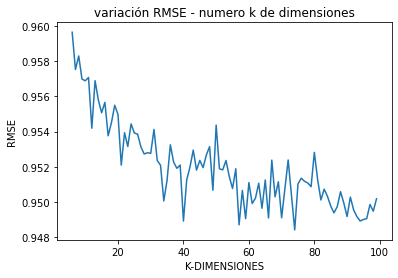

In [71]:
sns.lineplot(data = results_1, x = 'K-DIMENSIONES', y = 'RMSE')
plt.title('variación RMSE - numero k de dimensiones')
plt.show()

### 4.2 Para un k fijo, aumente la regularización para diferentes valores [0.001,0.01,0.1,1,10]. Evidencie el efecto que tiene esta variación en los parámetros obtenidos y en los errores, por ejemplo, comparando los tamaños de los parámetros.

<font color='red'>Nota: no correr las siguiente celda. Tiempo de ejecución alto. </font> 

In [72]:
%%time
rmse_2 = []

for each in [0.001, 0.01, 0.1, 1, 10]:  
    algo = SVD(n_factors = int(best_k), n_epochs = 200, biased = True, lr_all = 0.001, reg_all = each, init_mean = 0, init_std_dev = 0.01, verbose = False)
    algo.fit(train_data) 
    predictions = algo.test(validation_data)
    rmse_2.append(accuracy.rmse(predictions))

RMSE: 0.9502
RMSE: 0.9496
RMSE: 0.9674
RMSE: 1.0014
RMSE: 1.0920
Wall time: 4min 13s


In [73]:
results_2 = pd.DataFrame(list(zip(rmse_2, [0.001, 0.01, 0.1, 1, 10])), columns = ['RMSE','REGULARIZACION']).sort_values('RMSE')
results_2.head(5)

RMSE  REGULARIZACION
1  0.949629           0.010
0  0.950170           0.001
2  0.967358           0.100
3  1.001426           1.000
4  1.092034          10.000

In [74]:
print('El menor RMSE fue ' + str(min(rmse_2)) + ' cuyo valor de K-dimensiones es 0.1 .')
best_reg = 0.100

El menor RMSE fue 0.9496288112880248 cuyo valor de K-dimensiones es 0.1 .


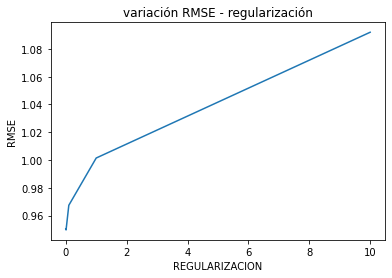

In [75]:
sns.lineplot(data = results_2, x = 'REGULARIZACION', y = 'RMSE')
plt.title('variación RMSE - regularización')
plt.show()

### 4.3 ¿Según los resultados obtenidos, qué otros hiperparámetros cambiaría y en qué dirección para mejorar el performance del modelo?

In [76]:
n_factors = best_k
n_epochs = [50, 100, 150, 200]
biased = [True, False]
lr_all = [0.001,0.01,0.1,1]
reg_all = best_reg
init_mean = np.arange(0, mean, 0.8)
init_std_dev = np.arange(0, 1, 0.2)
verbose = [False]

In [101]:
iterables = list(product(n_epochs, biased, lr_all,  init_mean, init_std_dev))
iterables

[(50, True, 0.001, 0.0, 0.0),
 (50, True, 0.001, 0.0, 0.2),
 (50, True, 0.001, 0.0, 0.4),
 (50, True, 0.001, 0.0, 0.6000000000000001),
 (50, True, 0.001, 0.0, 0.8),
 (50, True, 0.001, 0.8, 0.0),
 (50, True, 0.001, 0.8, 0.2),
 (50, True, 0.001, 0.8, 0.4),
 (50, True, 0.001, 0.8, 0.6000000000000001),
 (50, True, 0.001, 0.8, 0.8),
 (50, True, 0.001, 1.6, 0.0),
 (50, True, 0.001, 1.6, 0.2),
 (50, True, 0.001, 1.6, 0.4),
 (50, True, 0.001, 1.6, 0.6000000000000001),
 (50, True, 0.001, 1.6, 0.8),
 (50, True, 0.001, 2.4000000000000004, 0.0),
 (50, True, 0.001, 2.4000000000000004, 0.2),
 (50, True, 0.001, 2.4000000000000004, 0.4),
 (50, True, 0.001, 2.4000000000000004, 0.6000000000000001),
 (50, True, 0.001, 2.4000000000000004, 0.8),
 (50, True, 0.001, 3.2, 0.0),
 (50, True, 0.001, 3.2, 0.2),
 (50, True, 0.001, 3.2, 0.4),
 (50, True, 0.001, 3.2, 0.6000000000000001),
 (50, True, 0.001, 3.2, 0.8),
 (50, True, 0.01, 0.0, 0.0),
 (50, True, 0.01, 0.0, 0.2),
 (50, True, 0.01, 0.0, 0.4),
 (50, True, 0

<font color='red'>Nota: no correr las siguiente celda. Tiempo de ejecución alto. </font> 

In [78]:
%%time
rmse_3 = []

for n_epochs_o, biased_o, lr_all_o,  init_mean_o, init_std_dev_o in iterables:  
    algo = SVD(n_factors = best_k,
               reg_all = best_reg,
               verbose = False,
               n_epochs = n_epochs_o,
               biased = biased_o,
               lr_all = lr_all_o,
               init_mean = init_mean_o,
               init_std_dev = init_std_dev_o)
    algo.fit(train_data) 
    predictions = algo.test(validation_data)
    rmse_3.append(accuracy.rmse(predictions))

RMSE: 0.9771
RMSE: 0.9899
RMSE: 1.1220
RMSE: 1.3375
RMSE: 1.4871
RMSE: 1.1380
RMSE: 1.1661
RMSE: 1.2720
RMSE: 1.3717
RMSE: 1.4769
RMSE: 1.1297
RMSE: 1.1558
RMSE: 1.2589
RMSE: 1.3828
RMSE: 1.4780
RMSE: 1.1184
RMSE: 1.1387
RMSE: 1.2377
RMSE: 1.3516
RMSE: 1.4420
RMSE: 1.1055
RMSE: 1.1067
RMSE: 1.1647
RMSE: 1.2444
RMSE: 1.3504
RMSE: 0.9751
RMSE: 0.9579
RMSE: 0.9765
RMSE: 1.0119
RMSE: 1.0362
RMSE: 1.0240
RMSE: 1.0029
RMSE: 1.0167
RMSE: 1.0454
RMSE: 1.0567
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.0152
RMSE: 0.9869
RMSE: 0.9879
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 2.3707
RMSE: 1.8025

RMSE: 0.9775
RMSE: 0.9810
RMSE: 0.9895
RMSE: 0.9930
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.0153
RMSE: 0.9898
RMSE: 0.9894
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 2.3875
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 1.8025
RMSE: 2.7796
RMSE: 1.1162
RMSE: 1.2222
RMSE: 1.3221
RMSE: 1.4155
RMSE: 1.0722
RMSE: 1.0759
RMSE: 1.1414

In [120]:
results_3 = pd.DataFrame(iterables, columns = ['n_epochs', 'biased', 'lr_all',  'init_mean', 'init_std_dev']).merge(pd.DataFrame([best_k]*len(results_3), columns = ['best_k']).merge(pd.DataFrame([best_reg]*len(results_3), columns = ['best_reg']), how = 'inner', left_index = True, right_index = True), how = 'inner', left_index = True, right_index = True).merge(pd.DataFrame(rmse_3, columns = ['rmse']), how = 'inner', left_index = True, right_index = True).sort_values('rmse')
results_3.head()

n_epochs  biased  lr_all  init_mean  init_std_dev  best_k  best_reg  \
426       150    True    0.01        0.0           0.2      89       0.1   
626       200    True    0.01        0.0           0.2      89       0.1   
226       100    True    0.01        0.0           0.2      89       0.1   
627       200    True    0.01        0.0           0.4      89       0.1   
26         50    True    0.01        0.0           0.2      89       0.1   

         rmse  
426  0.954603  
626  0.954959  
226  0.955429  
627  0.957439  
26   0.957865

In [124]:
print('El mejor modelo se consigue con los sigueintes hiperparametros:')
results_3.head(1).to_dict('records')

El mejor modelo se consigue con los sigueintes hiperparametros:


[{'n_epochs': 150,
  'biased': True,
  'lr_all': 0.01,
  'init_mean': 0.0,
  'init_std_dev': 0.2,
  'best_k': 89,
  'best_reg': 0.1,
  'rmse': 0.9546026653796033}]

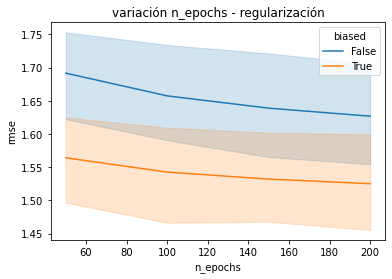

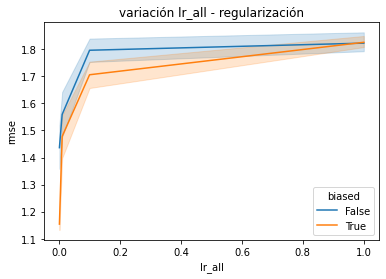

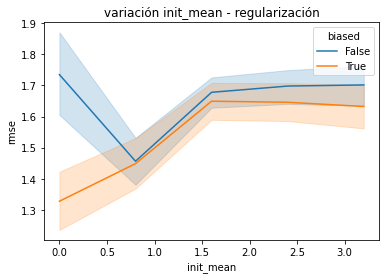

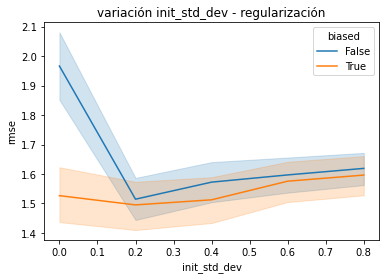

In [125]:
for each in ['n_epochs', 'lr_all',  'init_mean', 'init_std_dev']:
    sns.lineplot(data = results_3[[each, 'rmse','biased']], x = each, y = 'rmse', hue = 'biased')
    plt.title(f'variación {each} - regularización')
    plt.show()

In [ ]:
DESCRIBIR VARIACION SEGUN GRAFICAS DE HIPERPARAMETROSñ

### RMSE en conjunto de test y comparación de RMSE

In [129]:
best_params = results_3.head(1).to_dict('records')[0]
best_params

{'n_epochs': 150,
 'biased': True,
 'lr_all': 0.01,
 'init_mean': 0.0,
 'init_std_dev': 0.2,
 'best_k': 89,
 'best_reg': 0.1,
 'rmse': 0.9546026653796033}

In [138]:
best_algo = SVD(n_factors = best_k,
               reg_all = best_reg,
               verbose = False,
               n_epochs = best_params['n_epochs'],
               biased = best_params['biased'],
               lr_all = best_params['lr_all'],
               init_mean = best_params['init_mean'],
               init_std_dev = best_params['init_std_dev'])

best_algo.fit(train_data)

In [142]:
print('------------- Resultados rmse del mejor modelo -----------')
print(f'El rmse de entrenamiento es: {accuracy.rmse(best_algo.test(train_data_2))}')
print(f'El rmse de validación es: {accuracy.rmse(best_algo.test(validation_data))}')
print(f'El rmse de prueba es: {accuracy.rmse(best_algo.test(test_data))}')

------------- Resultados rmse del mejor modelo -----------
RMSE: 0.6356
El rmse de entrenamiento es: 0.6355779628573156
RMSE: 0.9543
El rmse de validación es: 0.9543050887915363
RMSE: 0.9766
El rmse de prueba es: 0.9766000700673009


### Comparación del comportamiento de rmse en todos los conjuntos de datos de los 10 mejores modelos

In [163]:
train_rmse = []
val_rmse = []
test_rmse = []

for each in np.arange(1,11,1):
    loop_params = results_3.head(11).iloc[each,:].to_dict()

    loop_algo = SVD(n_factors = best_k,
               reg_all = best_reg,
               verbose = False,
               n_epochs = loop_params['n_epochs'],
               biased = loop_params['biased'],
               lr_all = loop_params['lr_all'],
               init_mean = loop_params['init_mean'],
               init_std_dev = loop_params['init_std_dev'])

    loop_algo.fit(train_data)
    train_rmse.append(accuracy.rmse(loop_algo.test(train_data_2)))
    val_rmse.append(accuracy.rmse(loop_algo.test(validation_data)))
    test_rmse.append(accuracy.rmse(loop_algo.test(test_data)))

RMSE: 0.6326
RMSE: 0.9551
RMSE: 0.9734
RMSE: 0.6427
RMSE: 0.9534
RMSE: 0.9729
RMSE: 0.6330
RMSE: 0.9543
RMSE: 0.9767
RMSE: 0.6703
RMSE: 0.9553
RMSE: 0.9735
RMSE: 0.6359
RMSE: 0.9592
RMSE: 0.9815
RMSE: 0.6339
RMSE: 0.9689
RMSE: 0.9894
RMSE: 0.6431
RMSE: 0.9646
RMSE: 0.9851
RMSE: 0.7410
RMSE: 0.9653
RMSE: 0.9789
RMSE: 0.6368
RMSE: 0.9690
RMSE: 0.9910
RMSE: 0.7660
RMSE: 0.9676
RMSE: 0.9850


In [166]:
comparative = pd.DataFrame(list(zip(train_rmse, val_rmse, test_rmse)), columns = ['train_rmse','validation_rmse','test_rmse'])
comparative.head(10)

train_rmse  validation_rmse  test_rmse
0    0.632638         0.955053   0.973409
1    0.642668         0.953374   0.972934
2    0.633034         0.954297   0.976693
3    0.670274         0.955331   0.973473
4    0.635901         0.959158   0.981531
5    0.633857         0.968860   0.989418
6    0.643084         0.964624   0.985089
7    0.741009         0.965269   0.978917
8    0.636846         0.968974   0.991042
9    0.765971         0.967646   0.984978

<AxesSubplot:>

Utilizando los rmse de los mejores 10 modelos encontrados en el grid search se puede envidenciar el comportamiento de los errores en cada conjunto de datos. Siendo el error de entrenamiento el mas bajo, luego el de validación y por ultimo el de entrenamiento


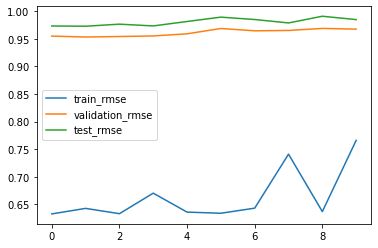

In [174]:
display(sns.lineplot(data = comparative, dashes = False))
print('Utilizando los rmse de los mejores 10 modelos encontrados en el grid search se puede envidenciar el comportamiento de los errores en cada conjunto de datos. Siendo el error de entrenamiento el mas bajo, luego el de validación y por ultimo el de entrenamiento')